In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "scan_agent"

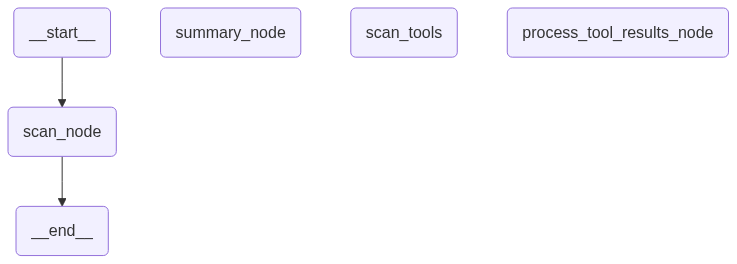

In [2]:
from IPython.display import Image, display

from scan_agent.graph import create_scan_graph

graph = create_scan_graph()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
import uuid
from datetime import timedelta

from langchain_core.runnables.config import RunnableConfig

from agent_core.graph import run_graph
from agent_core.state import ReActUsage, Target, Tools, ToolsUsage
from agent_core.tool import CURL_TOOL, FFUF_TOOL
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

state = {
    "target": Target(
        url="https://app.aifounder.app/", description="Local REST API target", type="web"
    ),
    "usage": ReActUsage(limit=25),
    "tools_usage": ToolsUsage(
        limits={
            FFUF_TOOL.name: 2,
            CURL_TOOL.name: 5,
        }
    ),
    "tools": Tools(tools=[FFUF_TOOL, CURL_TOOL]),
}
thread_id = str(uuid.uuid4())[:8]
config = RunnableConfig(
    max_concurrency=10,
    recursion_limit=25,
    configurable={"thread_id": thread_id},
)

print(f"🚀 Starting improved event processing with thread ID: {thread_id}")
print("=" * 80)

event = await run_graph(graph, state, config)

🚀 Starting improved event processing with thread ID: 4dfa3624


2025-06-19 10:01:48,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 10:01:48,705 - INFO - Routing to tools node: scan_tools
2025-06-19 10:01:48,708 - INFO - Event received: {'scan_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VGowntcYF02sctdrPT2Evrwc', 'function': {'arguments': '{"target": "https://app.aifounder.app/", "wordlist_type": "common", "extensions": "php,html,js,txt"}', 'name': 'ffuf_directory_scan'}, 'type': 'function'}, {'id': 'call_PBk9DSgOfc0rd3aZeOjUEQ0T', 'function': {'arguments': '{"curl_args": "-X GET https://app.aifounder.app/ -I"}', 'name': 'curl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1645, 'total_tokens': 1730, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_to

CancelledError: 

In [ ]:
event

{'summary_node': {'summary': ScanAgentSummary(discovered_endpoints=[DiscoveredEndpoint(path='http://localhost:8000/docs', status_code=200, content_type='text/html; charset=utf-8', notes='Swagger UI documentation. Publicly accessible. Reveals API structure and endpoints.'), DiscoveredEndpoint(path='http://localhost:8000/redoc', status_code=200, content_type='text/html; charset=utf-8', notes='ReDoc documentation. Publicly accessible. Alternative API docs.'), DiscoveredEndpoint(path='http://localhost:8000/openapi.json', status_code=200, content_type='application/json', notes='OpenAPI schema. Publicly accessible. Full API contract including endpoint details and descriptions of vulnerabilities.'), DiscoveredEndpoint(path='http://localhost:8000/health', status_code=200, content_type='application/json', notes='Health check endpoint. Publicly accessible. Leaks status, timestamp, and version.'), DiscoveredEndpoint(path='http://localhost:8000/users', status_code=200, content_type='application/js

In [ ]:
from IPython.display import Markdown

states = list(graph.get_state_history(config))

Markdown(states[0].values['summary'].to_markdown())

# 🔍 Reconnaissance Summary Report

---

## 📋 Executive Summary

The reconnaissance phase identified a FastAPI-based REST API running on uvicorn (Python) with extensive documentation and a large, exposed attack surface. At least 13 endpoints were discovered, many of which are publicly accessible and lack authentication or authorization. Critical vulnerabilities are present, including command injection, SQL injection, path traversal, arbitrary file upload, and sensitive information exposure. User data and the full API schema are leaked without restriction. The risk to business operations is severe: attackers could achieve remote code execution, exfiltrate sensitive data, and escalate privileges with minimal effort. Immediate remediation is required, prioritizing the closure of critical vulnerabilities and restricting public access to sensitive endpoints. Attackers require only basic skills to exploit these flaws, and the likelihood of compromise is extremely high.

## 💻 Technology Stack

### 🟢 uvicorn

**Confidence:** High

**Evidence:** HTTP response header 'server: uvicorn'

### 🟢 FastAPI

**Confidence:** High

**Evidence:** Presence of /docs (Swagger UI), /redoc, /openapi.json, and FastAPI-specific HTML and OpenAPI schema

### 🟢 Python

**Confidence:** High

**Evidence:** uvicorn is a Python ASGI server; FastAPI is a Python framework

## 🔍 Discovered Endpoints

| Path | Status | Content Type | Notes |
|------|--------|--------------|-------|
| `http://localhost:8000/docs` | 200 | text/html; charset=utf-8 | Swagger UI documentation. Publicly accessible. Reveals API structure and endpoints. |
| `http://localhost:8000/redoc` | 200 | text/html; charset=utf-8 | ReDoc documentation. Publicly accessible. Alternative API docs. |
| `http://localhost:8000/openapi.json` | 200 | application/json | OpenAPI schema. Publicly accessible. Full API contract including endpoint details and descriptions of vulnerabilities. |
| `http://localhost:8000/health` | 200 | application/json | Health check endpoint. Publicly accessible. Leaks status, timestamp, and version. |
| `http://localhost:8000/users` | 200 | application/json | Returns all users. No authentication required. Leaks usernames, emails, and roles. |
| `http://localhost:8000/user/{user_id}` | 200 | application/json | Get user by ID. No authorization check. Potential for user enumeration. |
| `http://localhost:8000/login` | 200 | application/json | Login endpoint. Weak authentication and information disclosure described in OpenAPI. |
| `http://localhost:8000/search` | 200 | application/json | Search users. Simulated SQL injection vulnerability per OpenAPI. |
| `http://localhost:8000/admin/system` | 200 | application/json | System info endpoint. Simulated command injection vulnerability via 'cmd' parameter. |
| `http://localhost:8000/admin/debug` | 200 | application/json | Debug info endpoint. Simulated sensitive information exposure. |
| `http://localhost:8000/files/{file_path}` | 200 | application/json | Read file endpoint. Simulated path traversal vulnerability. |
| `http://localhost:8000/user` | 200 | application/json | Create user endpoint. No input validation or password policy. |
| `http://localhost:8000/upload` | 200 | application/json | Upload file endpoint. No file validation. |

## 🔓 Sensitive Information

### 🔴 User Data

**Location:** `http://localhost:8000/users`

**Risk Level:** High

**Details:** Leaked usernames, emails, and roles for admin, user, and guest accounts.

### 🔴 API Schema

**Location:** `http://localhost:8000/openapi.json`

**Risk Level:** High

**Details:** Full OpenAPI schema including endpoint descriptions and explicit vulnerability notes.

### 🟡 Health/Version Info

**Location:** `http://localhost:8000/health`

**Risk Level:** Medium

**Details:** API version, timestamp, and health status exposed.

## 🚨 Vulnerabilities

### 🔴 CRITICAL Severity (4)

#### Command Injection

**Location:** `/admin/system`

**Description:** The /admin/system endpoint allows command execution via the 'cmd' parameter (simulated).

**Impact:** Remote code execution, full system compromise.

#### SQL Injection

**Location:** `/search`

**Description:** The /search endpoint is vulnerable to SQL injection (simulated).

**Impact:** Database compromise, data exfiltration, privilege escalation.

#### Path Traversal

**Location:** `/files/{file_path}`

**Description:** The /files/{file_path} endpoint allows reading arbitrary files (simulated).

**Impact:** Disclosure of sensitive files, credential theft, further exploitation.

#### Arbitrary File Upload

**Location:** `/upload`

**Description:** The /upload endpoint allows file uploads with no validation (simulated).

**Impact:** Remote code execution, persistent access, malware hosting.

### 🟠 HIGH Severity (5)

#### Unauthenticated User Data Exposure

**Location:** `/users`

**Description:** The /users endpoint exposes usernames, emails, and roles without authentication.

**Impact:** Information disclosure, user enumeration, potential for phishing or privilege escalation.

#### Sensitive Information Exposure

**Location:** `/admin/debug`

**Description:** The /admin/debug endpoint exposes sensitive debug information (simulated).

**Impact:** Leakage of environment variables, credentials, or internal state.

#### Weak Authentication

**Location:** `/login`

**Description:** The /login endpoint has weak authentication and information disclosure (simulated).

**Impact:** Account takeover, privilege escalation.

#### No Input Validation/User Creation

**Location:** `/user`

**Description:** The /user endpoint allows user creation with no input validation or password policy.

**Impact:** Account enumeration, weak accounts, privilege escalation.

#### No Authorization on User Data

**Location:** `/user/{user_id}`

**Description:** The /user/{user_id} endpoint lacks authorization checks.

**Impact:** User enumeration, privilege escalation.

### 🟡 MEDIUM Severity (1)

#### OpenAPI Schema Disclosure

**Location:** `/openapi.json`

**Description:** The /openapi.json endpoint is publicly accessible and details all endpoints, including vulnerabilities.

**Impact:** Attackers can plan precise attacks using the full API contract.

## ⚠️ Risk Assessment

### 🔴 Remote Code Execution

**Priority:** Critical

**Details:** Command injection and arbitrary file upload allow full system compromise.

**Rationale:** Endpoints explicitly allow command execution and file upload without validation.

### 🔴 Sensitive Data Exposure

**Priority:** High

**Details:** User data, API schema, and debug info are publicly accessible.

**Rationale:** No authentication or authorization required for sensitive endpoints.

### 🔴 Database Compromise

**Priority:** Critical

**Details:** SQL injection vulnerability allows attacker to access or modify database.

**Rationale:** OpenAPI spec and endpoint description confirm SQLi risk.

### 🔴 Privilege Escalation

**Priority:** High

**Details:** Weak authentication and lack of input validation enable account takeover.

**Rationale:** Endpoints lack proper security controls.

### 🔴 Attack Surface

**Priority:** High

**Details:** Multiple unauthenticated and unprotected endpoints.

**Rationale:** Recon revealed at least 13 endpoints, many with critical vulnerabilities.

## ⚔️ Attack Recommendations

### 🔴 1. Command Injection

**Target:** `/admin/system`

**Priority:** 1

**Description:** Send crafted 'cmd' parameter to execute arbitrary OS commands.

**Prerequisites:** None; endpoint is public.


### 🟠 2. SQL Injection

**Target:** `/search`

**Priority:** 2

**Description:** Inject SQL payloads via 'q' parameter to extract or modify database data.

**Prerequisites:** None; endpoint is public.


### 🟡 3. Path Traversal

**Target:** `/files/{file_path}`

**Priority:** 3

**Description:** Use '../' sequences in 'file_path' to access sensitive files.

**Prerequisites:** None; endpoint is public.


### 🟢 4. Arbitrary File Upload

**Target:** `/upload`

**Priority:** 4

**Description:** Upload malicious files (e.g., web shells, scripts) to gain persistent access.

**Prerequisites:** None; endpoint is public.


### 🔵 5. Sensitive Info Harvesting

**Target:** `/admin/debug, /openapi.json, /users`

**Priority:** 5

**Description:** Collect leaked credentials, environment variables, and user data for further attacks.

**Prerequisites:** None; endpoints are public.


### ⚪ 6. Authentication/Authorization Bypass

**Target:** `/user/{user_id}, /user, /login`

**Priority:** 6

**Description:** Attempt privilege escalation or account takeover due to lack of proper controls.

**Prerequisites:** None; endpoints are public.


---

*Report generated by Scan Agent* 🤖


In [ ]:
states[0].values['summary'].to_markdown()

"# 🔍 Reconnaissance Summary Report\n\n---\n\n## 📋 Executive Summary\n\nThe reconnaissance phase identified a FastAPI-based REST API running on uvicorn (Python) with extensive documentation and a large, exposed attack surface. At least 13 endpoints were discovered, many of which are publicly accessible and lack authentication or authorization. Critical vulnerabilities are present, including command injection, SQL injection, path traversal, arbitrary file upload, and sensitive information exposure. User data and the full API schema are leaked without restriction. The risk to business operations is severe: attackers could achieve remote code execution, exfiltrate sensitive data, and escalate privileges with minimal effort. Immediate remediation is required, prioritizing the closure of critical vulnerabilities and restricting public access to sensitive endpoints. Attackers require only basic skills to exploit these flaws, and the likelihood of compromise is extremely high.\n\n## 💻 Technolo

In [ ]:
states[0].values['summary'].model_dump_json()

'{"discovered_endpoints":[{"path":"http://localhost:8000/docs","status_code":200,"content_type":"text/html; charset=utf-8","notes":"Swagger UI documentation. Publicly accessible. Reveals API structure and endpoints."},{"path":"http://localhost:8000/redoc","status_code":200,"content_type":"text/html; charset=utf-8","notes":"ReDoc documentation. Publicly accessible. Alternative API docs."},{"path":"http://localhost:8000/openapi.json","status_code":200,"content_type":"application/json","notes":"OpenAPI schema. Publicly accessible. Full API contract including endpoint details and descriptions of vulnerabilities."},{"path":"http://localhost:8000/health","status_code":200,"content_type":"application/json","notes":"Health check endpoint. Publicly accessible. Leaks status, timestamp, and version."},{"path":"http://localhost:8000/users","status_code":200,"content_type":"application/json","notes":"Returns all users. No authentication required. Leaks usernames, emails, and roles."},{"path":"http: